In [10]:
import cvxpy
import cvxpy as cp
import numpy as np
from tqdm.auto import tqdm
import argparse
import time
import matplotlib.pyplot as plt
parser = argparse.ArgumentParser()
parser.add_argument("--N", default=10, type=int, help="# train points")
parser.add_argument("--n_alias", default=2, type=int, help="# alias points")
parser.add_argument("--a", default=.2, type=float, help="alpha. See paper-experiment 1")
parser.add_argument("--theta", default=1, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--noise", default=0.1, type=float)
parser.add_argument("--plot_bruteforce", action="store_true", help="Plot BruteForce prediction")
parser.add_argument("--plot_sccf", action="store_true", help="Plot SCCF prediction")
parser.add_argument("--step_size", default=0.2, type=float, help="SCCF step size")
parser.add_argument("--maxiter", default=25, type=int, help="SCCF # iter")
parser.add_argument("--tol", default=1e-5, type=float, help="SCCF tol")
args = parser.parse_args("--N 10 --n_alias 2 --a 0.2 --plot_bruteforce --plot_sccf".split())

np.random.seed(args.seed)

# Primal Problem

We consider the problem in the first experiment:
Finding the predefined $\theta$, knowing the observations:
$$
\begin{aligned}
    x_i\sim \mathcal{N}(0,1)\forall i\in[0, N)\\
    y_i\sim (-1)^j\mathcal{N}(\theta*x_i, 0.1)\forall i\in[0, N)\\ 
    j = \begin{cases}
    1 \text{ total of flipped ys are given}\\
    2 \text{ otherwise}
    \end{cases}
\end{aligned}
$$

Here is the data-generating code: 

In [11]:
N = args.N
true_theta = args.theta
x = np.random.normal(0, 1, size=(N,))
z = np.random.normal(0, 1, size=(N,))
y = true_theta * x  # this is true function we need to estimate of linear regression
noisy_y = y + args.noise * z  # make it noisy
indices = np.arange(N)
np.random.shuffle(indices)
y_with_outliers = np.copy(y)
y_with_outliers[indices[:args.n_alias]] *= -1

# Clipped Regression Problem
Obviously, this problem can be solved by a clipped convex problem.
To handle the alias, we add a heuristic hyper-parameter $\alpha$ to limit the maximal difference between prediction and observation.
The clipped problem is: 

$$
\begin{equation}
\begin{aligned}
& \text{minimize}_\theta & \sum_i{\min((\theta x_i - y_i)^2, \alpha)} + (0.1)\theta^2\\
& \text{subject to} &  \alpha\geq0 
\end{aligned}
\end{equation}
$$

## SCCF Method

The following is the implementation of the paper method, which also measures the running time:

In [12]:
def sccf_sol(x, y_with_outliers, a, N, args):
    import sccf
    start_time = time.time()
    theta = cp.Variable(1)
    x_train = cp.Parameter(N, value=x)
    y_train = cp.Parameter(N, value=y_with_outliers)

    f_is = [sccf.MinExpression(cp.square(x_train[t] * theta[0] - y_train[t]), a)
            for t in range(N)]
    objective = sccf.SumOfMinExpressions(f_is) + 0.1 * theta[0] ** 2
    prob = sccf.Problem(objective)
    prob.solve(step_size=args.step_size, maxiter=args.maxiter, tol=args.tol, verbose=True)
    end_time = time.time()
    running_time = end_time - start_time
    return theta[0].value, running_time

## Brute Force Method

Alternatively, we can solve $2^N$ convex sub-problems, then decide the optimal $\theta$.
Each sub-problem is:

$$
\begin{equation}
\begin{aligned}
& \text{minimize}_\theta & \sum_i{\left(\phi_i*(\theta x_i - y_i)^2 + (1-\phi_i)*\alpha\right)} + (0.1)\theta^2\\
& \text{subject to} &  \phi_i\in\{0,1\}\forall i\in[0, N) 
\end{aligned}
\end{equation}
$$

Having, at most, $2^N$ solutions, we consider the minimal objective then decide the $\theta^*$.
The following is the implementation of the brute force method, which also measures the running time:



In [13]:
def repeatable_permutations(n):
    permutations = []

    def generate_permutations(prefix, n):
        if n == 0:
            permutations.append([int(x) for x in prefix])
        else:
            generate_permutations(prefix + '0', n - 1)
            generate_permutations(prefix + '1', n - 1)

    generate_permutations('', n)
    return np.array(permutations)

def brute_force_sol(x, y_with_outliers, a, N, args):
    sub_probs = []
    lams = repeatable_permutations(N)
    start_time = time.time()
    for i, lam in tqdm(enumerate(lams), "brute_force_sol: Solving sub-problems...."):

        theta = cp.Variable(1)
        x_train = cp.Parameter(N, value=x)
        y_train = cp.Parameter(N, value=y_with_outliers)
        f_is = []
        constraints = []
        for t, l in enumerate(lam):
            if l:
                f_is.append(cp.square(x_train[t] * theta[0] - y_train[t]))
                constraints.append(cp.square(x_train[t] * theta[0] - y_train[t]) <= a)
            else:
                f_is.append(a)

        objective = cvxpy.Minimize(cvxpy.sum(f_is) + 0.1 * theta[0] ** 2)
        prob = cvxpy.Problem(objective)
        prob.solve()
        if prob.status not in ["infeasible", "unbounded"]:
            sub_probs.append([prob, theta.value, lam])

    objectives = [prob[0].objective.value for prob in sub_probs]
    end_time = time.time()
    min_idx = np.argmin(objectives)
    theta = sub_probs[min_idx][1]
    running_time = end_time - start_time
    return theta[0], running_time

# Comparison

In this experiment, we compare the optimality and computation complexity of two approach; by two metrics:
- Absolute distance to the given $\theta$ from the output prediction
- Computation time (in seconds)

brute_force_sol: Solving sub-problems....: 0it [00:00, ?it/s]

0001 | 1.0779e+00 | 5.0000e-01
0002 | 1.0757e+00 | 2.0000e-01
0003 | 1.0680e+00 | 1.0000e-01
0004 | 1.0626e+00 | 2.0000e-01
0005 | 1.0898e+00 | 2.0000e-01
0006 | 1.0626e+00 | 2.0000e-01
0007 | 1.0898e+00 | 2.0000e-01
0008 | 1.0626e+00 | 2.0000e-01
0009 | 1.0898e+00 | 2.0000e-01
0010 | 1.0626e+00 | 2.0000e-01
0011 | 1.0902e+00 | 2.0000e-01
0012 | 1.0626e+00 | 2.0000e-01
0013 | 1.0898e+00 | 2.0000e-01
0014 | 1.0626e+00 | 2.0000e-01
0015 | 1.0898e+00 | 2.0000e-01
0016 | 1.0626e+00 | 2.0000e-01
0017 | 1.0930e+00 | 2.0000e-01
0018 | 1.0626e+00 | 2.0000e-01
0019 | 1.0898e+00 | 2.0000e-01
0020 | 1.0626e+00 | 2.0000e-01
0021 | 1.0916e+00 | 2.0000e-01
0022 | 1.0626e+00 | 2.0000e-01
0023 | 1.0898e+00 | 2.0000e-01
0024 | 1.0626e+00 | 2.0000e-01
0025 | 1.0898e+00 | 2.0000e-01
Terminated (maximum number of iterations reached).
------------------------------
Difference with golden theta: brute force: 0.028581247536902055; sccf: 0.8855898880794746
Running time: brute force: 7.80s; sccf: 0.23s
-------

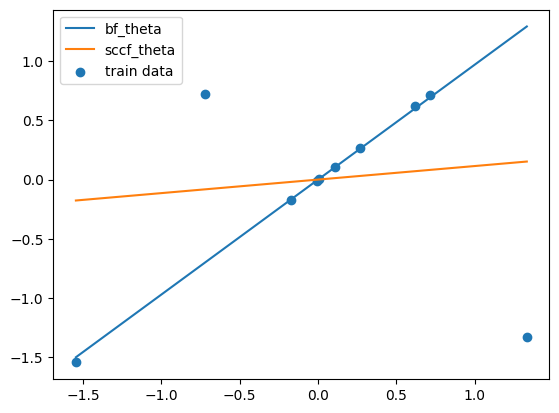

In [14]:
a =  args.a
bf_theta, bf_runtime = brute_force_sol(x, y_with_outliers, a, N, args)
sccf_theta, sccf_runtime = sccf_sol(x, y_with_outliers, a, N, args)
print('-' * 30)
print(
    f'Difference with golden theta: brute force: {abs(bf_theta - true_theta)}; sccf: {abs(sccf_theta - true_theta)}')
print(f'Running time: brute force: {bf_runtime:.2f}s; sccf: {sccf_runtime:.2f}s')
print('-' * 30)

# sample x
sample_x = np.linspace(np.amin(x), np.amax(x), 30)

if args.plot_bruteforce:
    predicted_y = sample_x * bf_theta
    plt.plot(sample_x, predicted_y, label='bf_theta')

if args.plot_sccf:
    predicted_y = sample_x * sccf_theta
    plt.plot(sample_x, predicted_y, label='sccf_theta')

if args.plot_sccf or args.plot_bruteforce:
    plt.scatter(x, y_with_outliers, label='train data')
    plt.legend()
    plt.show()


After running with different $N$, we have the following table:

| N  | Error Brute Force | Error SCCF | Runtime BF | Runtime SCCF |
|----|-------------------|------------|------------|-------------|
| 10 | 0.0286            | 0.8856     | 6.44       | 0.19        |
| 11 | 0.0189            | 0.1807     | 13.59      | 0.04        |
| 12 | 0.0222            | 0.0724     | 29.14      | 0.04        |
| 13 | 0.0134            | 0.3045     | 61.90      | 0.25        |
| 14 | 0.0118            | 0.2439     | 140.67     | 0.08        |
| 15 | 0.0114            | 0.2562     | 293.08     | 0.09        |

SCCF seems to be low accurate, but very fast!